# Customer Segmentation with RFM clustering analysis
The dataset was downloaded from 
https://www.kaggle.com/datasets/jihyeseo/online-retail-data-set-from-uci-ml-repo

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [2]:
data = pd.read_excel('data/Online Retail.xlsx')

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


ข้อมูลสำคัญอย่าง CustomerID, Description ขาดหาย ไม่ครบตามจำนวนแถว >> ต้อง Droup ทิ้งในแถวที่หาย

In [4]:
data.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country'],
      dtype='object')

In [5]:
data.columns = ['InvoiceNo', 'StockCode', 'Product', 'Quantity', 'InvoiceDate',
    'UnitPrice', 'CustomerID', 'Country']

เปลี่ยนชื่อ Column ที่ไม่สอดคล้อง  Description > Product

In [6]:
data.head()

,InvoiceNo,StockCode,Product,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [7]:
data.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


ต้องการทำ RFM ข้อมูลสำคัญที่ต้องใช้ในการพิจารณาคือ 1.วันที่ 2.จำนวนครั้ง 3.ยอด

In [8]:
# Make CustomerID as string
data['CustomerID'] = data['CustomerID'].astype(str)

In [9]:
# Remove rows with missing CustomerID
data = data[data['CustomerID'] != 'nan']

In [10]:
# number of missing values for each column
data.isnull().sum(axis=0)

InvoiceNo      0
StockCode      0
Product        0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

In [11]:
# Show rows with negative Quantity or UnitPrice
Return_Discount = data.loc[(data['Quantity'] < 0) | (data['UnitPrice'] < 0)]

พิจารณาข้อมูล QTY ที่เป็นลบ >> เป็นเคสที่ลูกค้านำของมาคืน หรือทำ DisCount 


In [12]:
# compute quantity x UnitPrice
data['amount'] = data['Quantity'] * data['UnitPrice']
#Choose rows with negative quantity or unitPrice    
negative_data =   data.loc[(data['Quantity'] < 0) | (data['UnitPrice'] < 0)]
# total Amount for negative data
negative_data['amount'].sum()


-611342.0900000001

ยอดรวมของ Discount และ Return

In [13]:
#choose rows with positive quantity and unitPrice
possitive_data = data.loc[(data['Quantity'] > 0) & (data['UnitPrice'] > 0)]
# total Amount for positive data
possitive_data['amount'].sum()

8911407.904

ดังนั้นเมื่อพิจารณา ยอดขายที่เป็นบวก เทียบกับยอดขายที่เป็นลบ พบว่า ยอดขายที่เป็นลบ เป็นเพียง 6.86% เท่านั้น จึงพิจารณา Droup ทิ้ง 

In [14]:
# Remove rows with negative Quantity or UnitPrice
data = data.loc[(data['Quantity'] >= 0) & (data['UnitPrice'] >= 0)]

สโคปวิเคราะห์ข้อมูล data ที่ Quantity >= 0 และ UnitPrice >= 0

In [15]:
# Range of InvoiceDate
data['InvoiceDate'].min(), data['InvoiceDate'].max()

(Timestamp('2010-12-01 08:26:00'), Timestamp('2011-12-09 12:50:00'))

เพื่อดูว่า invoice date อยู่ในช่วงเวลาใด จากคำตอบคือ InviceDate เริ่มต้นคือ 2010-12-01 08:26:00 และ ล่าสุดคือ 2011-12-09 12:50:00

In [16]:
# How many customers are there?
len(data['CustomerID'].unique())

4339

จำนวนลูกค้าที่เราใช้วิเคราะห์มีทั้งหมด 4,339 ราย

In [17]:
# Compute Quantity x UnitPrice
data['Amount'] = data['Quantity'] * data['UnitPrice']

คำนวณหายอดรวมของการซื้อก่อน เนื่องจากว่า ในข้อมูลให่ QTY และราคาต่อชิ้นมา 

In [18]:
# For each customer, how many orders they made?
num_orders = data.groupby('CustomerID')['InvoiceNo'].nunique()
# Rename the column to Number of Orders
num_orders = num_orders.rename('Number of Orders')
num_orders

CustomerID
12346.0     1
12347.0     7
12348.0     4
12349.0     1
12350.0     1
           ..
18280.0     1
18281.0     1
18282.0     2
18283.0    16
18287.0     3
Name: Number of Orders, Length: 4339, dtype: int64

1. หาว่า แต่ละลูกค้าซื้อของกี่ครั้ง โดยนับจาก เลข invoice
2. แก้ไขชื่อ Column จาก InvoiceNo เป็น Number of Orders

In [19]:
# For each customer, how many items they bought?
num_items = data.groupby(['CustomerID'])['Quantity'].sum()
# For each customer, how much money they spent total?
money_spent = data.groupby(['CustomerID'])['Amount'].sum()

1.หาจำนวน 

In [20]:
money_spent.describe()

count      4339.000000
mean       2053.793018
std        8988.248381
min           0.000000
25%         307.245000
50%         674.450000
75%        1661.640000
max      280206.020000
Name: Amount, dtype: float64

In [21]:
# Change InvoiceDate to datetime
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])

In [22]:
# For each customer, the amount of time since their last order in days counting from 2012-01-01
recency = (pd.to_datetime('2012-01-01') - data.groupby(['CustomerID'])['InvoiceDate'].max()).dt.days
# Rename to recency
recency = recency.rename('recency')

In [23]:
# For each customer, the time being customer in days counting from 2012-01-01
retention = (pd.to_datetime('2012-01-01') - data.groupby(['CustomerID'])['InvoiceDate'].min()).dt.days

# Rename to lifetime
retention.rename('lifetime', inplace=True)

retention.describe()


count    4339.000000
mean      244.782899
std       117.883623
min        22.000000
25%       134.000000
50%       270.000000
75%       348.000000
max       395.000000
Name: lifetime, dtype: float64

In [40]:
# combine num_orders num_items money_spent recency
rfm = pd.concat([num_orders, num_items, money_spent, recency, retention], axis=1)
rfm

,Number of Orders,Quantity,Amount,recency,lifetime
CustomerID,,,,,
12346.0,1,74215,77183.60,347,347
12347.0,7,2458,4310.00,24,389
12348.0,4,2341,1797.24,97,380
12349.0,1,631,1757.55,40,40
12350.0,1,197,334.40,332,332
...,...,...,...,...,...
18280.0,1,45,180.60,299,299
18281.0,1,54,80.82,202,202
18282.0,2,103,178.05,29,148


In [41]:
# Compute frequency as NumInvoices / (lifetime / 30)
rfm['frequency'] = rfm['Number of Orders'] / (rfm['lifetime'] / 30)
# Drop NumInvoices and Quantity and lifetime
rfm.drop(['Number of Orders', 'Quantity','lifetime'], axis=1, inplace=True)

In [42]:
rfm.describe()

,Amount,recency,frequency
count,4339.000000,4339.000000,4339.000000
mean,2053.793018,114.041484,0.544938
std,8988.248381,100.007757,0.649331
min,0.000000,22.000000,0.075949
25%,307.245000,39.000000,0.211268
50%,674.450000,72.000000,0.384615
75%,1661.640000,163.500000,0.666667
max,280206.020000,395.000000,15.949367


In [43]:
# Show rows where Amount is greater than 3 standard deviations
rfm.loc[rfm['Amount'] > 3 * rfm['Amount'].std()].sort_values('Amount', ascending=False)

,Amount,recency,frequency
CustomerID,,,
14646.0,280206.02,23,5.904255
18102.0,259657.30,22,4.627249
17450.0,194550.79,30,3.547558
16446.0,168472.50,22,0.264317
14911.0,143825.06,23,15.265823
12415.0,124914.53,46,1.754875
14156.0,117379.63,31,4.198473
17511.0,91062.38,24,2.354430
16029.0,81024.84,60,4.784810


In [44]:
data[data['CustomerID'] == '14646.0']

,InvoiceNo,StockCode,Product,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,amount,Amount
37952,539491,21981,PACK OF 12 WOODLAND TISSUES,12,2010-12-20 10:09:00,0.29,14646.0,Netherlands,3.48,3.48
37953,539491,21986,PACK OF 12 PINK POLKADOT TISSUES,12,2010-12-20 10:09:00,0.29,14646.0,Netherlands,3.48,3.48
37954,539491,22720,SET OF 3 CAKE TINS PANTRY DESIGN,2,2010-12-20 10:09:00,4.95,14646.0,Netherlands,9.90,9.90
37955,539491,21931,JUMBO STORAGE BAG SUKI,1,2010-12-20 10:09:00,1.95,14646.0,Netherlands,1.95,1.95
37956,539491,22613,PACK OF 20 SPACEBOY NAPKINS,2,2010-12-20 10:09:00,0.85,14646.0,Netherlands,1.70,1.70
...,...,...,...,...,...,...,...,...,...,...
534958,581176,22908,PACK OF 20 NAPKINS RED APPLES,96,2011-12-07 15:19:00,0.72,14646.0,Netherlands,69.12,69.12
534959,581176,22907,PACK OF 20 NAPKINS PANTRY DESIGN,96,2011-12-07 15:19:00,0.72,14646.0,Netherlands,69.12,69.12
534960,581176,22029,SPACEBOY BIRTHDAY CARD,72,2011-12-07 15:19:00,0.36,14646.0,Netherlands,25.92,25.92
534961,581176,22712,CARD DOLLY GIRL,72,2011-12-07 15:19:00,0.36,14646.0,Netherlands,25.92,25.92


In [45]:
# z-score all columns of rfm
rfm_zscore = (rfm - rfm.mean()) / rfm.std()

In [204]:
!pip install scikit-learn

Defaulting to user installation because normal site-packages is not writeable


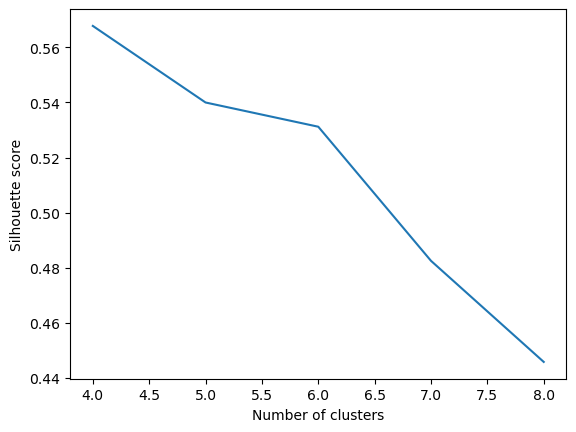

In [46]:
# k-means clustering with silouette score
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Try k from 4 to 8
k_range = range(4, 9)
# Silhouette score
silhouette = []
for k in k_range:
    # Create a KMeans instance with k clusters and n_
    kmeans = KMeans(n_clusters=k, random_state=10, n_init=20)
    # Fit the input data. Notice we don't use y
    kmeans.fit(rfm_zscore)
    # Append the silhouette score
    silhouette.append(silhouette_score(rfm_zscore, kmeans.labels_))
# Plot silhouette score vs k 
plt.plot(k_range, silhouette)
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')
plt.show()

In [47]:
# Show the centroids of the best model
best_model = KMeans(n_clusters=7, random_state=10)
best_model.fit(rfm_zscore)
best_model.cluster_centers_
# Add the column names to the centroids
centroids = pd.DataFrame(best_model.cluster_centers_, columns=rfm.columns)
centroids

c:\ProgramData\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


,Amount,recency,frequency
0,-0.124547,-0.239929,-0.319557
1,6.339685,-0.698456,5.138531
2,-0.168104,1.658117,-0.610687
3,24.884477,-0.897845,4.683140
4,7.876024,-0.913677,20.019637
5,0.527629,-0.814479,2.124256
6,0.006293,-0.732560,0.373621


In [49]:
# Convert centroids to original scale
centroids_original = centroids * rfm.std() + rfm.mean()
centroids_original

,Amount,recency,frequency
0,934.330600,90.046729,0.337440
1,59036.456190,44.190476,3.881544
2,542.831361,279.866044,0.148400
3,225721.652500,24.250000,3.585845
4,72845.453333,22.666667,13.544304
5,6796.250979,32.587234,1.924283
6,2110.360441,40.779753,0.787541


ผลวิเคราะห์ มีลูกคาทั้งหมด 7 กลุ่ม ได้แก่ 
กลุ่ม 0 เป็นลูกค้าที่ซื้อน้อย ความใหม่ประมาณหนึ่งเมื่อ 3 เดือนที่เเล้ว 
กลุ่ม 1 ลูกค้าที่ซื้อเยอะ ความใหม่ประมาณ 44 วันที่ผ่านมา เฉลี่ยซื้อวันละประมาณ 4 invoice อาจจะเป็น WHoleSalers รายย่อย เงินหมุนเวียนไม่เยอะ
กลุ่ม 2 กลุ่มลูกค้าซื้อต่ำ และไม่ซื้อมานานเเล้ว ประมาณ 280 วัน เป็นกลุ่มที่อาจไม่พอใจสินค้าและเลิกซื้อไป
กลุ่ม 3 กลุ่มที่จ่ายเยอะวันละประมาณ 4 invoice และซื้อล่าสุดเมื่อ 24 วันที่ผ่านมา อาจจเป็น WHoleSalers เนื่องจากซื้อเยอะ 
กลุ่ม 4 กลุ่มลูกจ่ายเยอะ วันละประมาณ 14 invoice และซื้อถี่ ล่าสุดคือ 22 วันที่เเล้ว อาจเป็น WHoleSalers รายย่อย
กลุ่ม 5 ซื้อพอประมาณ และซื้อเมื่อ 33 วันที่เเล้ว วันละประมาณ 2 Invoice น่าจะเป็นลูกค้าใหม่ที่กำลังเริ่มติดใจสินค้า 
กลุ่ม 6 ซื้อพอประมาณ ใกล้เคียงกับกลุ่มที่ 5 แต่ยอดขายต่ำกว่า คาด่าเป็นลูกค้าใหม่ที่กำลังซื้อไม่เยอะ

In [50]:
# Use GMM to cluster
from sklearn.mixture import GaussianMixture
# Use number of clusters from 3 to 12
k_range = range(3, 13)
# bic score
bic = []
for k in k_range:
    # Create a GaussianMixture instance with k clusters
    gmm = GaussianMixture(n_components=k, random_state=10, n_init=30)
    # Fit the input data. Notice we don't use y
    gmm.fit(rfm)
    # Append the bic score
    bic.append(gmm.bic(rfm))

<Axes: xlabel='k', ylabel='bic'>

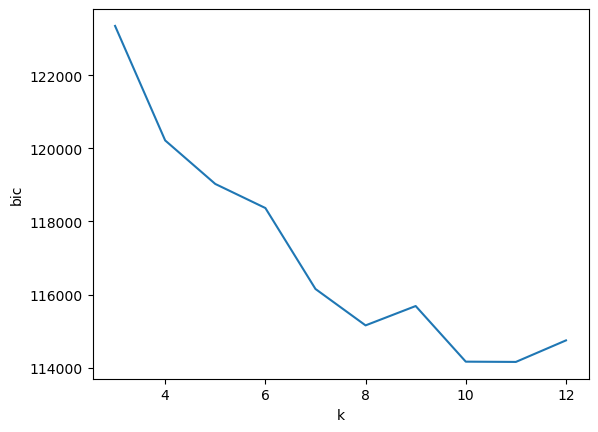

In [51]:
# Make a plot of bic score vs k using seaborn
scores = pd.DataFrame({'k': k_range, 'bic': bic})
sns.lineplot(x='k', y='bic', data=scores)

In [53]:
# fit GMM model with 5 clusters
gmm = GaussianMixture(n_components=5, random_state=10, n_init=30)
gmm.fit(rfm)
# Show the means of the clusters with the columns of rfm
centroids = pd.DataFrame(gmm.means_, columns=rfm.columns)
centroids

,Amount,recency,frequency
0,407.423527,213.311050,0.185492
1,16049.075005,112.492846,1.812282
2,225721.652500,24.250000,3.585845
3,2759.680507,35.275524,0.998120
4,1081.004742,70.254956,0.462559


ผลการแบ่ง Cluster มี 5 กลุ่ม 
กลุ่ม 0 ซื้อน้อย และซื้อเมื่อนานมาเเล้ว อาจเป็นลูกค้าที่อาจไม่พอใจสินค้า ไปจากเราเเล้ว 
กลุ่ม 1 รองลงมาจากกลุ่ม 2 ซื้อเยอะ เป็นสมาชิกตั้งแต่ต้นปี แต่อาจจะไม่บ่อยเท่ากลุ่ม 2 เฉลี่ยตกวันละ 2 invoice เป็น WHoleSalers รายย่อย
กลุ่ม 2 กลุ่มซื้อเยอะ และซื้อเมื่อ 24 วนที่ผ่านมา เฉลี่ยตกวันละ 4 invoice กลุ่มลูกค้า WHoleSalers รายใหญ่
กลุ่ม 3 กลุ่มลูกค้าที่ยอดซื้อดี ซื้อครั้งล่าสุดเมื่อ 35 วันที่เเล้ว เฉลี่ยวันละประมาณ 1 invoice คาดว่าเป็นลูกค้าที่กำลังติดใจ 
กลุ่ม 4 กลุ่มลูกค้าที่ยอดซื้อดี ซื้อครั้งล่าสุดเมื่อ 70 วันที่เเล้ว ความถี่ต่ำ อาจเป็นลูกค้าที่กำลังจะเปลี่ยนใจจากเรา > Churn


<Axes: xlabel='Amount', ylabel='frequency'>

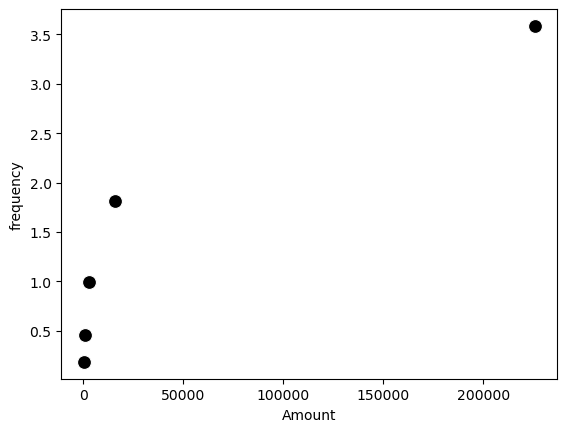

In [54]:
# Make scatter plots of Amount vs recency centroids using seaborn
sns.scatterplot(x='Amount', y='frequency', data=centroids, s=100, color='black')


In [55]:
print(rfm.columns)

Index(['Amount', 'recency', 'frequency'], dtype='object')


In [56]:
# Assign cluster labels to rfm
rfm['cluster'] = gmm.predict(rfm)

In [57]:
rfm['cluster']

CustomerID
12346.0    1
12347.0    3
12348.0    4
12349.0    3
12350.0    0
          ..
18280.0    0
18281.0    0
18282.0    4
18283.0    3
18287.0    4
Name: cluster, Length: 4339, dtype: int64

In [58]:
# Assign cluster labels from rfm to data by merging on the CustomerID
data = data.merge(rfm['cluster'], left_on='CustomerID', right_index=True)
data.head()

,InvoiceNo,StockCode,Product,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,amount,Amount,cluster
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,15.30,1
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,20.34,1
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,22.00,1
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,20.34,1
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,20.34,1


In [59]:
# Recode cluster 0 to lost, 1 to Loyal big, 2 to Loyal giant, 3 to regular, 4 to Loyal small
data['cluster'] = data['cluster'].replace({0: 'Lost', 1: 'Loyal big', 2: 'Loyal giant', 3: 'Regular', 4: 'Loyal small'})


In [60]:
# What are the common Product for each cluster?
data.groupby(['cluster'])['Product'].value_counts().groupby(['cluster']).head(5)

cluster      Product                            
Lost         WHITE HANGING HEART T-LIGHT HOLDER     288
             REGENCY CAKESTAND 3 TIER               219
             PARTY BUNTING                          192
             ASSORTED COLOUR BIRD ORNAMENT          186
             REX CASH+CARRY JUMBO SHOPPER           169
Loyal big    REGENCY CAKESTAND 3 TIER               394
             JUMBO BAG RED RETROSPOT                354
             WHITE HANGING HEART T-LIGHT HOLDER     322
             LUNCH BAG RED RETROSPOT                281
             PARTY BUNTING                          238
Loyal giant  SPACEBOY LUNCH BOX                      25
             ROUND SNACK BOXES SET OF4 WOODLAND      24
             CREAM HEART CARD HOLDER                 22
             DOLLY GIRL LUNCH BOX                    19
             WOOD BLACK BOARD ANT WHITE FINISH       19
Loyal small  WHITE HANGING HEART T-LIGHT HOLDER     671
             REGENCY CAKESTAND 3 TIER               520

กลุ่มสินค้าที่ลูกค้าแต่ละกลุ่มซื้อ ได้แก่
Lost         WHITE HANGING HEART T-LIGHT HOLDER     288
             REGENCY CAKESTAND 3 TIER               219
             PARTY BUNTING                          192
             ASSORTED COLOUR BIRD ORNAMENT          186
             REX CASH+CARRY JUMBO SHOPPER           169

Loyal big    REGENCY CAKESTAND 3 TIER               394
             JUMBO BAG RED RETROSPOT                354
             WHITE HANGING HEART T-LIGHT HOLDER     322
             LUNCH BAG RED RETROSPOT                281
             PARTY BUNTING                          238

Loyal giant  SPACEBOY LUNCH BOX                      25
             ROUND SNACK BOXES SET OF4 WOODLAND      24
             CREAM HEART CARD HOLDER                 22
             DOLLY GIRL LUNCH BOX                    19
             WOOD BLACK BOARD ANT WHITE FINISH       19

Loyal small  WHITE HANGING HEART T-LIGHT HOLDER     671
             REGENCY CAKESTAND 3 TIER               520
             ASSORTED COLOUR BIRD ORNAMENT          497
             PARTY BUNTING                          437
             JUMBO BAG RED RETROSPOT                419
             
Regular      WHITE HANGING HEART T-LIGHT HOLDER     736
             JUMBO BAG RED RETROSPOT                717
             LUNCH BAG RED RETROSPOT                625
             REGENCY CAKESTAND 3 TIER               583
             ASSORTED COLOUR BIRD ORNAMENT          564

In [62]:
#Total amount of sales for each cluster
total = data.groupby(['cluster'])['Amount'].sum().sort_values(ascending=False)
#make it percentage
total = total / total.sum() * 100
total

cluster
Loyal big      32.528409
Regular        29.507420
Loyal small    21.012377
Loyal giant    10.131807
Lost            6.819987
Name: Amount, dtype: float64

สรุปผล จากการทำ Clustering ของลูกค้า จะแบ่งออกเป็น 5 กลุ่ม พบว่า 
กลุ่ม Loyal giant  ไม่ได้ยอดขายสูงอย่างที่เราคิด
แต่ กลุ่ม Loyal big , Regular และ Loyal small เป็นกลุ่มที่ยอดขายสูง จะต้องดูแลลูค้าเป็นพิเศษ เนื่องจากยอดขายสูง
กลุ่ม Lost อาจจะไม่ต้องสนใจเพื่อดึงกลับมาเพราะเป็นกลุ่มน้อยมาก ควรสนใจกลุ่มหลัก